# Final Project - COMP/ELEC 576

Dongwook Kim and Fuad Hasan

In [1]:
!pip install tensorflow-io
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 83.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Packages
import os
import math
import random
from glob import glob
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import time
import copy

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
# Make temp folder in local
!mkdir -p /content/temp

ZIP_PATH = "/content/drive/MyDrive/Assignments/COMP_Project/data.zip"
!cp "$ZIP_PATH" /content/temp/


!ls -lh /content/temp

total 7.5G
-rw------- 1 root root 7.5G Dec  9 07:10 data.zip


In [5]:
# # Unzip
!unzip -q /content/temp/data.zip -d /content/temp/

In [21]:
# Hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 32         # 32, 64
DROPOUT_RATE = 0.3      # 0.3, 0.5
WEIGHT_DECAY = 0.05
EPOCHS = 10             # 50
LEARNING_RATE = 0.001
N_BLOCKS = 4

In [7]:
# 1. Load Data
local_root = "/content/temp/"
metadata_dir = "/content/temp/Sentinel1_metadata.csv"
input_dir = os.path.join(local_root, "data/S1")
target_dir = os.path.join(local_root, "data/Floodmaps")
model_prediction_result = "/content/drive/MyDrive/Assignments/COMP_Project/model_result"

input_files = sorted(glob(os.path.join(input_dir, "*.tif")))
target_files = sorted(glob(os.path.join(target_dir, "*.tif")))

input_dict = {os.path.basename(f): f for f in input_files}
target_dict = {os.path.basename(f): f for f in target_files}

all_files = sorted(set(input_dict.keys()) | set(target_dict.keys()))

df = pd.DataFrame({"filename": all_files,
                   "input_path": [input_dict.get(f, None) for f in all_files],
                   "target_path": [target_dict.get(f, None) for f in all_files]
                  })

df["status"] = df.apply(lambda row:
                        "matched" if row["input_path"] is not None and row["target_path"] is not None
                        else ("missing_input" if row["input_path"] is None else "missing_target"), axis=1
                        )

In [8]:
# 2. Train/Valid/Test Split
df_matched = df[df["status"] == "matched"].reset_index(drop=True)

train_df, temp_df = train_test_split(df_matched, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df["split"] = "train"
valid_df["split"] = "valid"
test_df["split"] = "test"

df_split = pd.concat([train_df, valid_df, test_df]).reset_index(drop=True)

In [9]:
# 3. Dataset
TOLERANCE = 1e-6
CLIP_MIN = -30.0
CLIP_MAX = 10.0
RANGE_MAX_MIN = CLIP_MAX - CLIP_MIN

class Sturm_Dataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_path = self.df.loc[idx, "input_path"]
        target_path = self.df.loc[idx, "target_path"]

        # --- 1. Input Image (SAR) Processing ---
        with rasterio.open(input_path) as src:
            # Read input image (already in dB scale)
            img = src.read().astype(np.float32)

        # SAR valid: Check for non-finite values (NaN/Inf)
        sar_valid = np.isfinite(img).all(axis=0)

        # --- 2. Target Mask Processing ---
        with rasterio.open(target_path) as src:
            mask_raw = src.read(1).astype(np.float32)
            nod = src.nodata

        # Label valid: Robustly check for NoData using a tolerance
        if nod is None:
            label_valid = np.ones_like(mask_raw, dtype=bool)
        else:
            label_valid = np.abs(mask_raw - nod) > TOLERANCE

        # Convert mask to 0/1 (Flood/No Flood)
        mask = (mask_raw > 0).astype(np.float32)

        # valid if both sar + label are valid
        valid_mask = sar_valid & label_valid

        valid_mask_tensor = np.expand_dims(valid_mask, axis=0)
        mask_tensor = np.expand_dims(mask, axis=0)

        return (
            torch.tensor(img, dtype=torch.float32),
            torch.tensor(mask_tensor, dtype=torch.float32),
            torch.tensor(valid_mask_tensor, dtype=torch.float32),
        )

In [10]:
train_dataset = Sturm_Dataset(df_split[df_split["split"] == "train"])
valid_dataset = Sturm_Dataset(df_split[df_split["split"] == "valid"])
test_dataset  = Sturm_Dataset(df_split[df_split["split"] == "test"])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True, generator=torch.Generator().manual_seed(42))
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

In [11]:
# Checking the first batch
# for imgs, masks, valids in train_loader:
for imgs, masks, valids in train_loader:
    print(f"Input batch shape: {imgs.shape}")
    print(f"Mask batch shape: {masks.shape}")
    print(f"Input min/max: {imgs.min().item():.4f}/{imgs.max().item():.4f}")
    print(f"Mask unique values: {masks.unique()}")

    break

Input batch shape: torch.Size([32, 2, 128, 128])
Mask batch shape: torch.Size([32, 1, 128, 128])
Input min/max: -0.4722/1.2913
Mask unique values: tensor([0., 1.])


In [12]:
# 4. Models
# 4.1 FCN-8
class FCN8(nn.Module):
    def __init__(self, in_ch=2, num_classes=1, dropout_rate=0.5):
        super(FCN8, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )

        self.score_pool3 = nn.Conv2d(256, num_classes, 1)
        self.score_pool4 = nn.Conv2d(512, num_classes, 1)
        self.score_pool5 = nn.Conv2d(512, num_classes, 1)

        self._initialize_weights()

    def forward(self, x):
        x1 = self.conv1(x)
        p1 = self.pool(x1)

        x2 = self.conv2(p1)
        p2 = self.pool(x2)

        x3 = self.conv3(p2)
        p3 = self.pool(x3)

        x4 = self.conv4(p3)
        p4 = self.pool(x4)

        x5 = self.conv5(p4)
        p5 = self.pool(x5)

        score5 = self.score_pool5(p5)
        score5_up = F.interpolate(score5, size=p4.shape[2:], mode='bilinear', align_corners=False)

        score4 = self.score_pool4(p4)
        score4_comb = score5_up + score4
        score4_up = F.interpolate(score4_comb, size=p3.shape[2:], mode='bilinear', align_corners=False)

        score3 = self.score_pool3(p3)
        score3_comb = score4_up + score3

        out = F.interpolate(score3_comb, size=x.shape[2:], mode='bilinear', align_corners=False)

        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [13]:
# 4.2 U-Net
def double_conv(in_channels, out_channels, dropout_rate=0.0):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        # nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        # nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
    if dropout_rate > 0:
        layers.append(nn.Dropout2d(dropout_rate))
    return nn.Sequential(*layers)


class UNet(nn.Module):
    def __init__(self, in_ch, out_ch, n_blocks=4, n_filters_start=64, filter_growth=2, dropout_rate=0):
        super().__init__()

        self.dconv_down1 = double_conv(in_ch, 64, dropout_rate)
        self.dconv_down2 = double_conv(64, 128, dropout_rate)
        self.dconv_down3 = double_conv(128, 256, dropout_rate)
        self.dconv_down4 = double_conv(256, 512, dropout_rate)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256, dropout_rate)
        self.dconv_up2 = double_conv(128 + 256, 128, dropout_rate)
        self.dconv_up1 = double_conv(128 + 64, 64, dropout_rate)

        self.conv_last = nn.Conv2d(64, out_ch, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)
        # probs = torch.sigmoid(out)

        return out

In [14]:
# 4.3 U-Net++
class UNetPP(nn.Module):
    def __init__(
        self,
        in_ch,
        out_ch,
        n_blocks=4,
        filters=None,
        dropout_rate=0.0
    ):
        super().__init__()

        if filters is None:
            filters = [64 * (2 ** i) for i in range(n_blocks)]
        assert len(filters) == n_blocks, "filters length must match n_blocks"

        self.conv00 = double_conv(in_ch,      filters[0], dropout_rate)
        self.conv10 = double_conv(filters[0], filters[1], dropout_rate)
        self.conv20 = double_conv(filters[1], filters[2], dropout_rate)
        self.conv30 = double_conv(filters[2], filters[3], dropout_rate)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv01 = double_conv(filters[0] + filters[1], filters[0], dropout_rate)
        self.conv11 = double_conv(filters[1] + filters[2], filters[1], dropout_rate)
        self.conv21 = double_conv(filters[2] + filters[3], filters[2], dropout_rate)

        self.conv02 = double_conv(filters[0]*2 + filters[1], filters[0], dropout_rate)
        self.conv12 = double_conv(filters[1]*2 + filters[2], filters[1], dropout_rate)

        self.conv03 = double_conv(filters[0]*3 + filters[1], filters[0], dropout_rate)

        self.final = nn.Conv2d(filters[0], out_ch, 1)

    def forward(self, x):

        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))

        x01 = self.conv01(torch.cat([x00, self.up(x10)], dim=1))
        x11 = self.conv11(torch.cat([x10, self.up(x20)], dim=1))
        x21 = self.conv21(torch.cat([x20, self.up(x30)], dim=1))

        x02 = self.conv02(torch.cat([x00, x01, self.up(x11)], dim=1))
        x12 = self.conv12(torch.cat([x10, x11, self.up(x21)], dim=1))

        x03 = self.conv03(torch.cat([x00, x01, x02, self.up(x12)], dim=1))

        return self.final(x03)

In [15]:
# Run the model
model = UNet(
    in_ch=2,
    out_ch=1,
    n_blocks=N_BLOCKS,
    dropout_rate=DROPOUT_RATE
).to(DEVICE)

In [16]:
# 5. Loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

pos_weight = torch.tensor([2.4]).to(DEVICE) # pos_weight = 0.706 / 0.294
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')


# class DiceLoss(nn.Module):
#     def __init__(self, smooth=1.0, reduction='mean'):
#         super(DiceLoss, self).__init__()
#         self.smooth = smooth
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         inputs = torch.sigmoid(inputs)

#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         intersection = (inputs * targets).sum()
#         dice_score = (2.0 * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
#         dice_loss = 1.0 - dice_score

#         if self.reduction == 'mean':
#             return dice_loss
#         elif self.reduction == 'sum':
#             return dice_loss * inputs.numel()
#         else:
#             return dice_loss

# criterion = DiceLoss(smooth=1.0, reduction='mean').to(DEVICE)

In [17]:
# 6. EarlyStopping:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False


In [18]:
# 7. Save model
def get_model_name(model_name, batch_size, dropout, epochs):
    D = int(dropout * 10) if dropout < 1 else int(dropout)
    return f"{model_name}_B{batch_size}D{D}E{epochs}"

model_prediction_result = "/content/drive/MyDrive/Assignments/COMP_Project/save"
best_model_filename = get_model_name("U-Net", BATCH_SIZE, DROPOUT_RATE, EPOCHS) + ".pth"
full_path = os.path.join(model_prediction_result, best_model_filename)

In [22]:
# 8. Run the model
early_stopper = EarlyStopping(patience=3, min_delta=1e-4)  # Patience = 10
best_val_loss = float('inf')
log_interval = 10

train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for batch_idx, (imgs, masks, valid_mask) in enumerate(train_loader):
        imgs, masks, valid_mask = imgs.to(DEVICE), masks.to(DEVICE), valid_mask.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss_tensor = criterion(outputs, masks.float())
        loss = (loss_tensor * valid_mask.float()).sum() / (valid_mask.sum() + 1e-8)

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)

        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks, valid_mask in valid_loader:
            imgs, masks, valid_mask = imgs.to(DEVICE), masks.to(DEVICE), valid_mask.to(DEVICE)

            outputs = model(imgs)
            loss_tensor = criterion(outputs, masks.float())
            loss = (loss_tensor * valid_mask.float()).sum() / (valid_mask.sum() + 1e-8)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(valid_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), full_path)
        print(f"** Best model saved: {full_path} **")

    if early_stopper(val_loss):
        print("Early stopping triggered!")
        break

Epoch 1 | Batch 0/541 | Loss: 0.8790
Epoch 1 | Batch 10/541 | Loss: 1.0357
Epoch 1 | Batch 20/541 | Loss: 0.8951
Epoch 1 | Batch 30/541 | Loss: 0.7446
Epoch 1 | Batch 40/541 | Loss: 0.8222
Epoch 1 | Batch 50/541 | Loss: 0.7661
Epoch 1 | Batch 60/541 | Loss: 0.7808
Epoch 1 | Batch 70/541 | Loss: 0.8543
Epoch 1 | Batch 80/541 | Loss: 0.7433
Epoch 1 | Batch 90/541 | Loss: 0.6782
Epoch 1 | Batch 100/541 | Loss: 0.6556
Epoch 1 | Batch 110/541 | Loss: 0.6312
Epoch 1 | Batch 120/541 | Loss: 0.8395
Epoch 1 | Batch 130/541 | Loss: 0.8024
Epoch 1 | Batch 140/541 | Loss: 0.8306
Epoch 1 | Batch 150/541 | Loss: 0.7361
Epoch 1 | Batch 160/541 | Loss: 0.6949
Epoch 1 | Batch 170/541 | Loss: 0.6884
Epoch 1 | Batch 180/541 | Loss: 0.8241
Epoch 1 | Batch 190/541 | Loss: 0.8693
Epoch 1 | Batch 200/541 | Loss: 0.7512
Epoch 1 | Batch 210/541 | Loss: 1.0343
Epoch 1 | Batch 220/541 | Loss: 0.7789
Epoch 1 | Batch 230/541 | Loss: 0.6874
Epoch 1 | Batch 240/541 | Loss: 0.6495
Epoch 1 | Batch 250/541 | Loss: 0.77

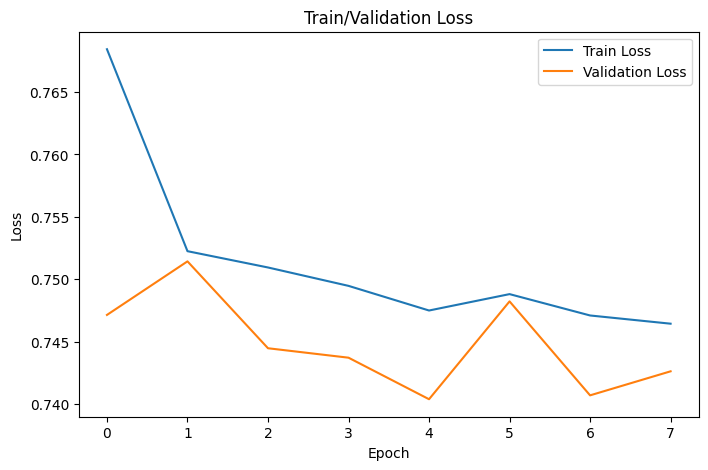

In [23]:
# 9. Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend()
plt.show()

In [24]:
# 10. Evaluate the model
def evaluate_model_simple(model, data_loader, device, dataset_name="Test Set", threshold=0.5):
    model.eval()
    total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0

    print(f"\n===== Evaluating {dataset_name} =====")

    with torch.no_grad():
        for batch_idx, (imgs, masks, valid_mask) in enumerate(data_loader):
            imgs = imgs.to(device)
            true_mask = masks.to(device).squeeze(1).bool()
            valid_mask = valid_mask.to(device).squeeze(1).bool()

            outputs = model(imgs)
            pred_mask = (torch.sigmoid(outputs) > threshold).squeeze(1)

            # Valid pixels
            pred_valid = pred_mask[valid_mask]
            true_valid = true_mask[valid_mask]

            # confusion matrix
            tp = (pred_valid & true_valid).sum().item()
            tn = (~pred_valid & ~true_valid).sum().item()
            fp = (pred_valid & ~true_valid).sum().item()
            fn = (~pred_valid & true_valid).sum().item()

            total_tp += tp
            total_tn += tn
            total_fp += fp
            total_fn += fn

    epsilon = 1e-7

    precision = total_tp / (total_tp + total_fp + epsilon)
    recall = total_tp / (total_tp + total_fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = total_tp / (total_tp + total_fp + total_fn + epsilon)
    oa = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn + epsilon)
    fpr = total_fp / (total_fp + total_tn + epsilon)
    mdr = total_fn / (total_tp + total_fn + epsilon)

    print(f"[{dataset_name}] Precision: {precision:.4f}")
    print(f"[{dataset_name}] Recall:    {recall:.4f}")
    print(f"[{dataset_name}] F1 Score:  {f1:.4f}")
    print(f"[{dataset_name}] IoU:       {iou:.4f}")
    print(f"[{dataset_name}] Accuracy:  {oa:.4f}")

    return f1, iou


In [25]:
# Validation
evaluate_model_simple(model, valid_loader, DEVICE, dataset_name="Validation Set")

# Test
evaluate_model_simple(model, test_loader, DEVICE, dataset_name="Test Set")


===== Evaluating Validation Set =====
[Validation Set] Precision: 0.6624
[Validation Set] Recall:    0.6500
[Validation Set] F1 Score:  0.6561
[Validation Set] IoU:       0.4882
[Validation Set] Accuracy:  0.8047

===== Evaluating Test Set =====
[Test Set] Precision: 0.6387
[Test Set] Recall:    0.6626
[Test Set] F1 Score:  0.6504
[Test Set] IoU:       0.4820
[Test Set] Accuracy:  0.7944


(0.6504355463761946, 0.48195965646739264)

In [26]:
# 11. Predicting on Harvey image for validation

from tqdm.notebook import tqdm

PATCH_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training band stats
TRAIN_STATS = {
    "vv": {"mean": 0.4532533777340789, "std": 0.151186964809762},
    "vh": {"mean": 0.27253500244271867, "std": 0.1730846364169936},
}

# Normalization (Assumed to be a z-score scaling)
def normalize(img, clip_min, clip_max, train_stats):
    img_norm = np.zeros_like(img, dtype=np.float32)

    for c in range(img.shape[0]):
        band = np.clip(img[c], clip_min, clip_max)
        mu = np.mean(band)
        sigma = np.std(band) + 1e-7

        if c == 0:   # VV
            target_mu = train_stats["vv"]["mean"]
            target_sigma = train_stats["vv"]["std"]
        else:        # VH
            target_mu = train_stats["vh"]["mean"]
            target_sigma = train_stats["vh"]["std"]

        standardized = (band - mu) / sigma
        matched = standardized * target_sigma + target_mu

        img_norm[c] = matched

        print(f"[Band {c}] μ_clip={mu:.4f}, σ_clip={sigma:.4f} → μ_target={target_mu:.4f}, σ_target={target_sigma:.4f}")

    return img_norm

# Inference
def inference(model, img_path):
    print("FINAL Normalization: Band-wise Clipping & Stat-Matching")

    with rasterio.open(img_path) as src:
        image = src.read().astype(np.float32)
        image = np.nan_to_num(image, nan=0.0, posinf=0.0, neginf=0.0)
        h, w = image.shape[1], image.shape[2]

    print("Applying Band-wise Stats Normalization")
    norm_image = normalize(
        image,
        CLIP_MIN,
        CLIP_MAX,
        TRAIN_STATS
    )

    print(f"[Check] Final VV Mean = {np.mean(norm_image[0]):.4f}")
    print(f"[Check] Final VH Mean = {np.mean(norm_image[1]):.4f}")

    pad_h = (PATCH_SIZE - (h % PATCH_SIZE)) % PATCH_SIZE
    pad_w = (PATCH_SIZE - (w % PATCH_SIZE)) % PATCH_SIZE
    image_padded = np.pad(norm_image, ((0, 0), (0, pad_h), (0, pad_w)), mode='constant')

    _, new_h, new_w = image_padded.shape
    prediction_map = np.zeros((new_h, new_w), dtype=np.uint8)

    model.eval()
    print("Running Inference...")

    with torch.no_grad():
        for i in tqdm(range(0, new_h, PATCH_SIZE)):
            for j in range(0, new_w, PATCH_SIZE):
                patch = image_padded[:, i:i+PATCH_SIZE, j:j+PATCH_SIZE]
                tensor = torch.from_numpy(patch).unsqueeze(0).to(DEVICE)

                output = model(tensor)
                prob = torch.sigmoid(output)

                pred = (prob > 0.5).cpu().numpy()[0, 0].astype(np.uint8)
                prediction_map[i:i+PATCH_SIZE, j:j+PATCH_SIZE] = pred

    final_pred = prediction_map[:h, :w]

    return final_pred

In [27]:
harvey_file = '/content/drive/MyDrive/Colab Notebooks/SARFLOOD/1_gee_sen1_preprocessing/merged_output/S1_VV_2017-08-30_DESCENDING_1_merged.tif'

pred = inference(model, harvey_file)

FINAL Normalization: Band-wise Clipping & Stat-Matching
Applying Band-wise Stats Normalization
[Band 0] μ_clip=-7.8631, σ_clip=5.3288 → μ_target=0.4533, σ_target=0.1512
[Band 1] μ_clip=-12.5071, σ_clip=7.9492 → μ_target=0.2725, σ_target=0.1731
[Check] Final VV Mean = 0.4532
[Check] Final VH Mean = 0.2725
Running Inference...


  0%|          | 0/177 [00:00<?, ?it/s]